# Cross Entropy Loss

**WTF**. It's sounds scary. But this is a way to create a loss function for model based on categories. 

In [2]:
from fastai2.vision.all import *
from utils import *

## Create a Linear MNIST Model

First of all, let's create a Linear MNIST model we create in lesson 4. <br/>
We can build stuff on top of that.

In [3]:
im_path = untar_data(URLs.MNIST)

In [4]:
im_path.ls()

(#2) [Path('/storage/data/mnist_png/training'),Path('/storage/data/mnist_png/testing')]

In [5]:
(im_path/"training").ls()

(#10) [Path('/storage/data/mnist_png/training/9'),Path('/storage/data/mnist_png/training/6'),Path('/storage/data/mnist_png/training/7'),Path('/storage/data/mnist_png/training/0'),Path('/storage/data/mnist_png/training/4'),Path('/storage/data/mnist_png/training/5'),Path('/storage/data/mnist_png/training/3'),Path('/storage/data/mnist_png/training/2'),Path('/storage/data/mnist_png/training/1'),Path('/storage/data/mnist_png/training/8')]

In [6]:
(im_path/"training/9").ls()

(#5949) [Path('/storage/data/mnist_png/training/9/39927.png'),Path('/storage/data/mnist_png/training/9/52230.png'),Path('/storage/data/mnist_png/training/9/39692.png'),Path('/storage/data/mnist_png/training/9/33246.png'),Path('/storage/data/mnist_png/training/9/59344.png'),Path('/storage/data/mnist_png/training/9/14364.png'),Path('/storage/data/mnist_png/training/9/53342.png'),Path('/storage/data/mnist_png/training/9/53238.png'),Path('/storage/data/mnist_png/training/9/35444.png'),Path('/storage/data/mnist_png/training/9/34176.png')...]

In [7]:
def load_images(p):
    return torch.stack([tensor(Image.open(im)).float()/255 for im in p.ls()])

In [8]:
train_3s = load_images(im_path/"training/3")

In [13]:
IMAGE_SIZE = 28 * 28

In [97]:
def get_dataloader(pa, pb):
    im_as = load_images(pa)
    im_bs = load_images(pb)
    X = torch.cat([im_as, im_bs]).view(-1, IMAGE_SIZE)
    Y = tensor([1] * len(im_as) + [0] * len(im_bs)).view(-1, 1)
    
    return DataLoader(list(zip(X, Y)), batch_size=224)
    

In [107]:
train_dl = get_dataloader(im_path/"training/3", im_path/"training/7")

In [108]:
valid_dl = get_dataloader(im_path/"testing/3", im_path/"testing/7")

In [109]:
dls = DataLoaders(train_dl, valid_dl)

In [110]:
def mnist_loss(preds, Y):
    return (torch.sigmoid(preds) - Y).abs().float().mean()

In [111]:
def mnist_accuracy(preds, Y):
    to_lables = (torch.sigmoid(preds) > 0.5).float()
    return (to_lables == Y).float().mean()

In [112]:
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=mnist_accuracy)

In [113]:
learn.fit(10, lr=1.)

epoch,train_loss,valid_loss,mnist_accuracy,time
0,0.651377,0.501589,0.495584,00:00
1,0.277016,0.322317,0.664377,00:00
2,0.098052,0.169148,0.844455,00:00
3,0.044316,0.106587,0.909715,00:00
4,0.026924,0.077354,0.934249,00:00
5,0.020900,0.061397,0.948970,00:00
6,0.018492,0.051749,0.958783,00:00
7,0.017321,0.045581,0.964181,00:00
8,0.016597,0.041368,0.965653,00:00
9,0.016063,0.038287,0.967125,00:00


## Current Model

Now we need to inspect how our model works. Specially, what are the prediction looks like.

In [131]:
X, Y = dls.one_batch()

In [119]:
preds, _ = learn.get_preds(dl=[(X, Y)])

In [130]:
preds.shape

torch.Size([224, 1])

As you can see, there's only one value in the prediction. 

If that's closer to 1, we will consider it as the first category. Otherwise it's in the second category.

## Multi Category Model

So, then how do we create a model for multiple categories. For that, our prediction should output columns for each of those categories.

This single column is knowns as an `activation`.

So, for a dataset with 3 categories, we need to model outputs 3 activations.

In [138]:
def get_dataloader_multi(pa, pb, pc):
    im_as = load_images(pa)
    im_bs = load_images(pb)
    im_cs = load_images(pc)
    X = torch.cat([im_as, im_bs, im_cs]).view(-1, IMAGE_SIZE)
    Y = tensor([1, 0, 0] * len(im_as) + [0, 1, 0] * len(im_bs) + [0, 0, 1] * len(im_bs)).view(-1, 3)
    
    return DataLoader(list(zip(X, Y)), batch_size=224)

In [139]:
dl_train_multi = get_dataloader_multi(im_path/"training/1", im_path/"training/3", im_path/"training/5")

In [143]:
dl_train_multi = get_dataloader_multi(im_path/"testing/1", im_path/"testing/3", im_path/"testing/5")

In [144]:
dls_multi = DataLoaders(dl_train_multi, dl_train_multi)

In [145]:
X, Y = dls_multi.one_batch()
X.shape, Y.shape

(torch.Size([224, 784]), torch.Size([224, 3]))

**See. Now our Y field has 3 rows** <br/>
This is what we can use for comparision.

In [152]:
model_multi = nn.Linear(IMAGE_SIZE, 3)
learn_multi = Learner(dls_multi, model_multi, opt_func=SGD, loss_func=mnist_loss, metrics=mnist_accuracy)

In [153]:
learn_multi.fit(10, lr=1.)

epoch,train_loss,valid_loss,mnist_accuracy,time
0,0.265795,0.376608,0.633851,00:00
1,0.139115,0.314301,0.696185,00:01
2,0.081577,0.251406,0.756933,00:01
3,0.059054,0.210231,0.796892,00:01
4,0.050169,0.180945,0.828013,00:00
5,0.046067,0.159394,0.849422,00:01
6,0.043708,0.142950,0.866805,00:01
7,0.042081,0.130028,0.879578,00:01
8,0.040879,0.119604,0.890583,00:01
9,0.039973,0.111011,0.899840,00:00


## Inspecting Predictions

In [ ]:
batchs = [(X, Y) for X,Y in dl_valid_multi]

### For 1

In [227]:
X, Y = batchs[0]

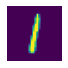

In [228]:
show_image(X[0].view(28, 28))

In [229]:
preds, _ = learn_multi.get_preds(dl=[(X, Y)])
preds[0:10]

tensor([[ 5.7056, -6.2831, -6.8403],
        [ 4.4437, -3.5263, -5.3365],
        [ 3.7389, -3.4902, -5.4278],
        [ 6.2782, -4.6612, -9.0761],
        [ 4.1674, -3.7777, -8.8463],
        [ 4.6673, -4.1561, -6.3468],
        [ 4.4836, -6.3118, -6.7488],
        [ 2.6784, -4.4407, -4.9066],
        [ 4.4113, -4.2673, -5.0067],
        [ 4.9756, -4.2178, -7.8005]])

### For 3

In [230]:
X, Y = batchs[int(len(batchs)/2)]

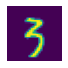

In [222]:
show_image(X[0].view(28, 28))

In [231]:
preds, _ = learn_multi.get_preds(dl=[(X, Y)])
preds[0:10]

tensor([[-10.2305,  -0.3753,   1.8203],
        [-17.5102,   2.2566,   1.2413],
        [ -5.2005,   0.7750,  -5.0070],
        [-14.4875,   2.4514,  -0.2367],
        [-13.8586,   1.2492,   2.2806],
        [-14.3546,   4.9763,  -5.3180],
        [-11.3367,   3.6425,  -2.1718],
        [ -6.3611,   0.4637,  -5.0690],
        [-12.6575,  -3.6268,   4.3331],
        [-12.4991,   0.8027,   1.1202]])

### For 5

In [234]:
X, Y = batchs[-1]

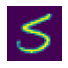

In [235]:
show_image(X[0].view(28, 28))

In [236]:
preds, _ = learn_multi.get_preds(dl=[(X, Y)])
preds[0:10]

tensor([[ -9.4513, -10.7563,   9.1642],
        [-10.5788, -14.1926,  10.8690],
        [ -9.3998,  -8.1178,   9.1397],
        [-13.5186,  -1.8406,   3.7893],
        [ -6.0125,  -6.5810,   6.6717],
        [-11.4188, -10.9247,  10.9720],
        [ -6.3575,  -5.6693,   5.0271],
        [-11.1941, -13.0930,  13.5128],
        [-12.7858,  -6.0266,   6.1448],
        [-12.1372,  -8.6255,  10.9774]])

As you can, see our model is now have 3 activations. It had worked for us even with our exisiting loss function. If you look at the preds, the related activation is positive.

But we can optimize the loss function to get some better results.